In [3]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
import math
import numpy as np
import seaborn as sbs
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import h5py

%matplotlib inline 
 
plt.rcParams['figure.figsize']=(8,6)
plt.style.use('ggplot')

In [4]:
base_currency = 'BTC'
#argument needs to be in the form of a string
def get250Day(ticker):
        ''' Acquire historical prices from CRYPTOCOMPARE '''
        url='https://min-api.cryptocompare.com/data/histoday'
        #will return a str
#prices from last 200 days
        parameters= {'fsym':ticker, 'tsym': base_currency, 'e': 'Bittrex', 'aggregate':1,'limit':250}
        
        r=requests.get(url,parameters)
        #handle this error in the calling class
        j_obj=r.json()
        if j_obj['Response']=='Error':
            print(j_obj)
            #print("fetch didn't work")
            raise RuntimeError
        raw_time=j_obj['Data']
        df=pd.DataFrame.from_dict(raw_time)
        df['time']=df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        df.index=pd.to_datetime(df.time)
        return(df)

In [5]:
mro_df=get250Day('XMR')

In [6]:
#prepare the dataframe for volatility calc
mro_df['hi_low_log']=mro_df.apply(lambda x: np.log(x['high']/x['low'])**2,axis=1)

In [7]:
mro_df['mid']=mro_df.apply(lambda x: np.mean([x['high'],x['low']]),axis=1)

In [8]:
def parkinson(df,window):
    #return(np.log(max(df['high'])/min(df['low']))**2
    return(np.sqrt((1/(4*np.log(2))*sum(df['hi_low_log']))/window))

In [9]:
def rolling_apply(df,window):
    i=np.arange(df.shape[0]+1-window)
    results=np.zeros(df.shape[0])
    for g in i:
        results[g+window-1]=parkinson(df.iloc[g:window+g,],window)
    return(results)

In [10]:
mro_df['vol_3day']=rolling_apply(mro_df,3)
mro_df['vol_15day']=rolling_apply(mro_df,15)

In [11]:
#rolling mean
roll_2=mro_df[['mid']].rolling(2).mean()
roll_5=mro_df[['mid']].rolling(5).mean()
roll_15=mro_df[['mid']].rolling(15).mean()

In [12]:
roll_2.columns=[i+'_MA2' for i in roll_2.columns]
roll_5.columns=[i+'_MA5' for i in roll_5.columns]
roll_15.columns=[i+'_MA15' for i in roll_15.columns]

In [13]:
#concatenate the dataframes
aggd=pd.concat([mro_df,roll_2,roll_5,roll_15],axis=1)

In [14]:
#test=aggd.apply(lambda x: (x[8]/x[11], x[8]/x[12], x[8]/x[13]),axis=1)
test2=aggd.apply(lambda x: x[8]/x[11],axis=1)
test5=aggd.apply(lambda x: x[8]/x[12],axis=1)
test15=aggd.apply(lambda x: x[8]/x[13],axis=1)

In [15]:
test_df=pd.concat([test2,test5,test15],axis=1)
test_df.shape

(251, 3)

In [16]:
var_df=pd.concat([aggd,test_df],axis=1)

In [17]:
lista=[x for x in var_df.columns]
lista[-3:]=['prop2','prop5','prop15']
var_df.columns=lista
var_df['mid_ln']=np.log(var_df['mid'])

In [18]:
#remove any rows with null values or impute zero values
var_df[['mid','vol_3day','vol_15day','prop2','prop5','prop15']]
var_df1=var_df.dropna(how='any')[['mid','vol_3day','vol_15day','prop2','prop5','prop15']]

In [24]:
#the more shifts/lags I apply, the more observations removed from the top (earliest) of the dataset
#will rename each column per the convention provided in the LTSM article... 
#will also need to shift each independent variable
#a function to iteratively append higher rows to later observations
lags=1 #applying three lags
temp_df=var_df1.iloc[:,1:]
print(temp_df.shape)
lista=[]
for i in np.arange(1,lags+1,1):
    temp_df=temp_df.shift(+1,axis=0)
    temp_df.columns=['var'+str(counter+1)+'(t-{})'.format(i) for counter, h in enumerate(temp_df.columns)]
    lista.append(temp_df)
agg_df=pd.concat(lista,axis=1)
agg_df['var(t)']=var_df1['mid']
print(agg_df.shape)

(237, 5)
(237, 6)


In [23]:
var_df1.tail()

,mid,vol_3day,vol_15day,prop2,prop5,prop15
time,,,,,,
2018-05-02 20:00:00,0.026030,0.036095,0.047595,0.983192,0.979971,0.914456
2018-05-03 20:00:00,0.025165,0.036482,0.047282,0.983104,0.961671,0.890513
2018-05-04 20:00:00,0.024820,0.033302,0.045920,0.993098,0.962127,0.888247
2018-05-05 20:00:00,0.024560,0.021414,0.043141,0.994735,0.963175,0.888760
2018-05-06 20:00:00,0.024265,0.016536,0.038247,0.993958,0.971844,0.890557


In [25]:
agg_df.tail()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var(t)
time,,,,,,
2018-05-02 20:00:00,0.033583,0.055129,1.016424,0.999889,0.942654,0.026030
2018-05-03 20:00:00,0.036095,0.047595,0.983192,0.979971,0.914456,0.025165
2018-05-04 20:00:00,0.036482,0.047282,0.983104,0.961671,0.890513,0.024820
2018-05-05 20:00:00,0.033302,0.045920,0.993098,0.962127,0.888247,0.024560
2018-05-06 20:00:00,0.021414,0.043141,0.994735,0.963175,0.888760,0.024265


In [19]:
agg_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var(t)
time,,,,,,
2017-09-11 20:00:00,0.045408,0.054861,1.012066,1.017468,1.000122,0.026610
2017-09-12 20:00:00,0.068757,0.056201,1.026950,1.059903,1.054374,0.027260
2017-09-13 20:00:00,0.080852,0.058457,0.951340,0.963918,0.965344,0.028770
2017-09-14 20:00:00,0.072930,0.057405,1.012392,0.987306,0.997961,0.026100
2017-09-15 20:00:00,0.052337,0.056462,0.981635,0.957490,0.967585,0.026755


In [20]:
agg_df.dropna(how='any',inplace=True)
agg_arr=agg_df.values.astype('float32')

In [21]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(agg_arr)

In [22]:
df=pd.DataFrame(scaled,columns=agg_df.columns)

In [2]:
df.tail()

NameError: name 'df' is not defined

In [23]:
values = df.values
n_train_days = 200
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 1, 5) (200,) (36, 1, 5) (36,)


In [24]:
train_y[-5:] #this agrees with the below
df['var(t)'][196:203]#this agrees with the above

196    0.567422
197    0.603412
198    0.616499
199    0.607619
200    0.641505
201    0.651788
202    0.642206
Name: var(t), dtype: float32

In [25]:
print(train_X[-5:])
print(df.iloc[:,:-1][196:203]) #these also appear to agree

[[[ 0.11717907  0.22628529  0.48373032  0.28484154  0.24923408]]

 [[ 0.12555352  0.22609432  0.60773277  0.36479807  0.31060219]]

 [[ 0.11281879  0.20475127  0.56191826  0.37844348  0.33458376]]

 [[ 0.08266919  0.18598877  0.51945639  0.35258698  0.32912719]]

 [[ 0.06284412  0.18408529  0.60133123  0.40703893  0.37642336]]]
     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
196   0.125554   0.226094   0.607733   0.364798   0.310602
197   0.112819   0.204751   0.561918   0.378443   0.334584
198   0.082669   0.185989   0.519456   0.352587   0.329127
199   0.062844   0.184085   0.601331   0.407039   0.376423
200   0.060581   0.148909   0.555881   0.391388   0.387047
201   0.040700   0.126691   0.518646   0.352968   0.369645
202   0.042891   0.087058   0.509171   0.316311   0.348128


In [26]:
print(test_X[-5:])
print(df.iloc[:,:-1].tail()) #these also appear to agree

[[[ 0.11404162  0.33274651  0.6099      0.33013773  0.23509908]]

 [[ 0.12963623  0.2581172   0.46159363  0.27880812  0.19047868]]

 [[ 0.13203654  0.25502551  0.46120119  0.23164463  0.15259004]]

 [[ 0.11229286  0.24153374  0.50580168  0.23282146  0.14900529]]

 [[ 0.03604933  0.21361877  0.51583004  0.23796892  0.15143275]]]
     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)
231   0.114042   0.332747   0.609900   0.330138   0.235099
232   0.129636   0.258117   0.461594   0.278808   0.190479
233   0.132037   0.255026   0.461201   0.231645   0.152590
234   0.112293   0.241534   0.505802   0.232821   0.149005
235   0.036049   0.213619   0.515830   0.237969   0.151433


In [27]:
print(test_y[-5:]) #this agrees with the below
print(df['var(t)'].tail())#this agrees with the above

[ 0.67398912  0.71465284  0.6730544   0.63262445  0.61649913]
231    0.673989
232    0.714653
233    0.673054
234    0.632624
235    0.616499
Name: var(t), dtype: float32


In [56]:
mdl = Sequential()
mdl.add(Dense(3, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(train_X, train_y, epochs=50, batch_size=1, verbose=0)

In [29]:
train_predict = mdl.predict(train_X)
test_predict = mdl.predict(test_X)

In [30]:
test_predict[-5:]

array([[ 0.49125102],
       [ 0.54586542],
       [ 0.51002502],
       [ 0.4997218 ],
       [ 0.53256649]], dtype=float32)

Concatenate the **test/predictive** dataset

In [45]:
test_X1.shape

(36, 5)

In [40]:
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#inv_yhat1 = np.concatenate((test_predict, test_X1), axis=1)
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
test_data = np.concatenate((test_X1,test_predict), axis=1)

Concatenate all the **training** data. This is a preliminary step to concatenating all the datasets:
- train_X.shape
- train_y.shape
- test_X.shape
- test_y.shape)

In [38]:
y_train=np.reshape(train_y,(train_y.shape[0],1))

In [41]:
train_data = np.concatenate((train_X1,y_train), axis=1)

Concatenate all the **test** data.

In [47]:
agg_data = np.concatenate((train_data,test_data), axis=0)

In [43]:
agg_data.shape

(236, 6)

In [53]:
inv_agg_data=scaler.inverse_transform(agg_data)
inv_agg_data.shape

(236, 6)

In [54]:
#predictions are stored in column 6
inv_agg_data[-15:,-1]

array([ 0.02880836,  0.02945114,  0.02987518,  0.02821835,  0.02623106,
        0.0259125 ,  0.02478649,  0.02434412,  0.02324585,  0.02250305,
        0.02214032,  0.02330879,  0.02254198,  0.02232155,  0.02302426], dtype=float32)

Compare the predicted to the actual data.

In [58]:
print(inv_agg_data[-5:,-1])
print(var_df1['mid'][-5:])

[ 0.02214032  0.02330879  0.02254198  0.02232155  0.02302426]
time
2018-05-01 20:00:00    0.026920
2018-05-02 20:00:00    0.026030
2018-05-03 20:00:00    0.025165
2018-05-04 20:00:00    0.024820
2018-05-05 20:00:00    0.024590
Name: mid, dtype: float64


In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
#inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = np.concatenate((test_y, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_y[-5:]

In [50]:
var_df1['mid'].tail()

time
2018-05-01 20:00:00    0.026920
2018-05-02 20:00:00    0.026030
2018-05-03 20:00:00    0.025165
2018-05-04 20:00:00    0.024820
2018-05-05 20:00:00    0.024590
Name: mid, dtype: float64

**Plot** both the actual data and predicted on the same axes.

In [65]:
agg_df.index[0:5]

DatetimeIndex(['2017-09-11 20:00:00', '2017-09-12 20:00:00',
               '2017-09-13 20:00:00', '2017-09-14 20:00:00',
               '2017-09-15 20:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [68]:
inv_agg_data.shape

(236, 6)

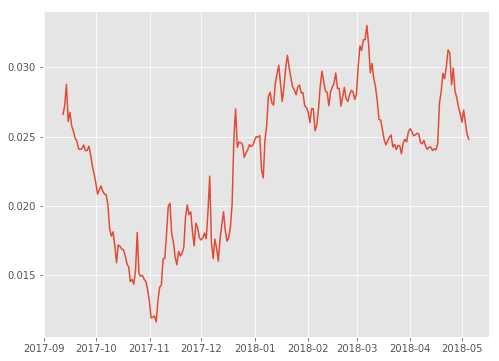

In [72]:
plt.plot(agg_df.index.values,agg_df['var(t)'])
plt.show()

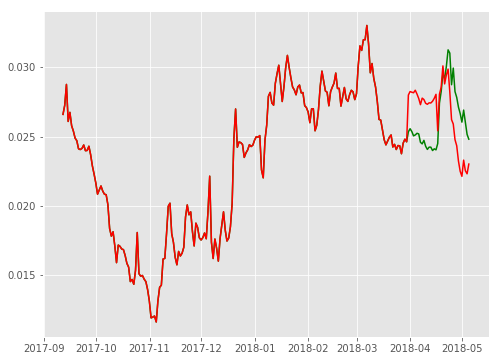

In [71]:
plt.close()
plt.plot(agg_df.index.values,agg_df['var(t)'],color='green')
plt.plot(agg_df.index.values,inv_agg_data[:,-1],color='red')
plt.show()

Compile the final model and save it.

In [75]:
values = df.values
# split into input and outputs
train_X, train_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print(train_X.shape, train_y.shape)

(236, 1, 5) (236,)


In [76]:
mdl = Sequential()
mdl.add(Dense(3, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
mdl.add(LSTM(6, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(train_X, train_y, epochs=30, batch_size=1, verbose=0)

In [79]:
mdl.save('/home/lechuza/Documents/CUNY/data_607/timeSeriesWork/lstm_model.h5')

Reload the model from disk.

In [ ]:
# load model from single file
model = load_model('lstm_model.h5')
# make predictions
yhat = model.predict(X, verbose=0)